In [1]:
import math
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
class TreeNode:
    def __init__(self,is_leaf,split):
        self.is_leaf = is_leaf
        self.split_vals = split
        self.prediction_class = None
        self.left = None
        self.right = None

    def print_node(self,split, level=0, text=''):
        print("Level:",level)
        if self.is_leaf:
            print('%s Leaf, predict y = %d' % (text, self.prediction_class))
        else:
            j,c = split
            print('%s x%d >= %f' % (text, j, c))
            self.left.print_node(self.left.split_vals,level+1, 'Left (Y)')
            self.right.print_node(self.right.split_vals,level+1, 'Right (N)')

In [3]:
class DecTree:

    '''
    Calculate the entropy of the given data. Assumes data is single column vector of output labels
    '''
    def entropy(self,data):
        if (len(data)==0):
            return 0
        p1 = np.mean(data[:,-1],axis=0) # calculate the probability of label '1'
        if (p1==0 or p1==1):
            return 0 # since entropy is p*log2(p) having p=0,1 would result in 0 entropy
        p2 = 1-p1
        return -1*((p1*np.log2(p1))+(p2*np.log2(p2)))

    '''

    '''
    def calc_split_entropy(self,data,split):
        j,c = split
        split1 = (data[:,int(j)]>=c).astype('float')
        split2 = (data[:,int(j)]<c).astype('float')
        p1 = split1.sum()/len(split1)
        if (p1==0 or p1==1):
            return 0
        p2 = 1-p1
        return -(p1*np.log2(p1)) -(p2*np.log2(p2))

    '''
    Calculate the information gain of given data. Assumes data is single column vector of output labels
    '''
    def calc_infogain(self,data,split):
        j,c = split
        target = self.entropy(data)
        split1 = data[data[:,int(j)]>=c]
        split2 = data[data[:,int(j)]<c]
        ent1 = self.entropy(split1)
        ent2 = self.entropy(split2)
        p1 = len(split1)/len(data)
        p2 = 1-p1
        split_info = (p1*ent1)+(p2*ent2)
        return target - split_info

    '''
    Calculates the information gain ratio
    '''
    def calc_gainratio(self,info_gain,split_ent):
        return info_gain/split_ent

    '''
    Calculates the candidate splits and returns them in the form (j,c)
    '''
    def get_splits(self,data):
        splits = []
        num_feats = data.shape[1]-1
        for col in range(num_feats): # iterate over columns
            data_sort = data[data[:,col].argsort()] # sort the matrix by the current column
            splits.append((col,data_sort[0,col])) # first value will be lowest so add as split
            for i in range(data_sort.shape[0]-1):
                if (data_sort[i,col] != data_sort[i+1,col]): # check for other splits
                    splits.append((col,data_sort[i+1,col]))
        return np.array(splits)

    '''
    Calculates the infogain, split entropy and resulting gain ratio of a given split
    '''
    def calc_splits(self,data,splits):
        for split in splits:
            infogain = self.calc_infogain(data,split) # calculate infogain from split
            split_ent = self.calc_split_entropy(data,split) # calculate split entropy from split
            if (split_ent > 0.0):
                gainratio = self.calc_gainratio(infogain,split_ent)
                print("X"+str(int(split[0]))+" >= "+str(split[1]),"Gain Ratio: "+str(gainratio))
            else:
                print("X"+str(int(split[0]))+" >= "+str(split[1]),"Info Gain:",infogain)

    '''
    Calculates which split from all potential splits provided the largest infogain ratio
    '''
    def get_max_split(self,data,splits):
        threshold = 0.00001
        max_gain_ratio = 0.0
        max_split = None
        for split in splits:
            j,c = split
            if (data[data[:,int(j)]>=c].shape[0]==0):
                continue
            if (np.unique(data[:,-1]).shape[0]==1):
                continue
            infogain = self.calc_infogain(data,split) # calculate infogain from split
            split_ent = self.calc_split_entropy(data,split) # calculate split entropy from split
            if (split_ent > threshold):
                gainratio = self.calc_gainratio(infogain,split_ent)
                if (gainratio > max_gain_ratio):
                    max_gain_ratio = gainratio
                    max_split = split
            else:
                continue
        return max_split

    def get_prediction_class(self,data):
        return 0 if sum(data[:,-1]==0) > sum(data[:,-1]==1) else 1

    '''
    Generates a decision tree by splitting upon the split yielding the largest gain. The root node is
    returned.
    '''
    def make_subtree(self,data):
        potential_splits = self.get_splits(data)
        max_split = self.get_max_split(data,potential_splits)
        if (max_split is None):
            leaf = TreeNode(True,max_split)
            leaf.prediction_class = self.get_prediction_class(data)
            return leaf
        node = TreeNode(False,max_split)
        j,c = max_split
        data_left = data[data[:,int(j)] >= c]
        node.left = self.make_subtree(data_left)
        data_right = data[data[:,int(j)] < c]
        node.right = self.make_subtree(data_right)
        return node

    def calc_error(self,root,test_data):
        count = 0
        for i in range(len(test_data)):
            pred = self.predict_class(root,test_data[i,:])
            #print(pred,test_data[i,-1])
            if (pred != test_data[i,-1]):
                count += 1
        return count/len(test_data)

    def count_num_node(self,node):
        left, right = 0, 0
        if node.left is not None:
            left = self.count_num_node(node.left)
        if node.right is not None:
            right = self.count_num_node(node.right)
        return left + right + 1

    def count_num_leaves(self,node):
        left, right = 0, 0
        if node.is_leaf:
            return 1
        if node.left is not None:
            left = self.count_num_leaves(node.left)
        if node.right is not None:
            right = self.count_num_leaves(node.right)
        return left + right

    def plot_boundary(self,data,root,num,title=None,filename=None):
        x_mins = data.min(axis=0)
        x_maxs = data.max(axis=0)
        x0_vals = np.linspace(x_mins[0],x_maxs[0],num)
        x1_vals = np.linspace(x_mins[1],x_maxs[1],num)
        xx, yy = np.meshgrid(x0_vals, x1_vals)
        xx, yy = xx.flatten(), yy.flatten()
        xx, yy = xx.reshape((len(xx), 1)), yy.reshape((len(yy), 1))
        class0 = []
        class1 = []
        for i in range(len(xx)):
            pred = self.predict_class(root,[xx[i],yy[i]])
            if (pred==0):
                class0.append([xx[i],yy[i]])
            else:
                class1.append([xx[i],yy[i]])
        class0 = np.array(class0)
        class1 = np.array(class1)
        plt.scatter(class0[:,0],class0[:,1],color='b',marker='o')
        plt.scatter(class1[:,0],class1[:,1],color='r',marker='o')
        if (title is not None):
            plt.title(title)
        if (filename is None):
            plt.show()
        else:
            plt.savefig(filename)
        return

    def predict_class(self,root,new_data):
        node = root
        while not node.is_leaf:
            (j, c) = node.split_vals
            node = node.left if new_data[int(j)] >= c else node.right
        return node.prediction_class

In [4]:
data = np.loadtxt("D3leaves.txt")
dt = DecTree()
pot_split = dt.get_splits(data)
dt.calc_splits(data,pot_split)

X0 >= 1.0 Info Gain: 0.0
X0 >= 10.0 Gain Ratio: 0.33155970728682876
X1 >= 1.0 Info Gain: 0.0
X1 >= 2.0 Gain Ratio: 0.33155970728682876
X1 >= 3.0 Gain Ratio: 0.17606518336876092


In [5]:
data_d3 = np.loadtxt('D3leaves.txt');
dt3 = DecTree()
root = dt3.make_subtree(data_d3)
print("Root Split:",root.split_vals)
if (not root.left.is_leaf):
    print("Left Split:",root.left.split_vals)
if (not root.right.is_leaf):
    print("Right Split:",root.right.split_vals)

Root Split: [ 0. 10.]
Right Split: [1. 3.]


In [6]:
data_d1 = np.loadtxt("D1.txt")
dt1 = DecTree()
root_d1 = dt1.make_subtree(data_d1)
print(dt1.count_num_leaves(root_d1))

2


In [7]:
data_d2 = np.loadtxt("D2.txt")
dt2 = DecTree()
root_d2 = dt2.make_subtree(data_d2)
print(dt2.count_num_leaves(root_d2))
print(root_d2.print_node(root_d2.split_vals))

31
Level: 0
 x0 >= 0.533076
Level: 1
Left (Y) x1 >= 0.228007
Level: 2
Left (Y) x1 >= 0.424906
Level: 3
Left (Y) Leaf, predict y = 1
Level: 3
Right (N) x0 >= 0.708127
Level: 4
Left (Y) Leaf, predict y = 1
Level: 4
Right (N) x1 >= 0.326250
Level: 5
Left (Y) x0 >= 0.595471
Level: 6
Left (Y) x0 >= 0.646007
Level: 7
Left (Y) Leaf, predict y = 1
Level: 7
Right (N) x1 >= 0.403494
Level: 8
Left (Y) Leaf, predict y = 1
Level: 8
Right (N) Leaf, predict y = 0
Level: 6
Right (N) Leaf, predict y = 0
Level: 5
Right (N) Leaf, predict y = 0
Level: 2
Right (N) x0 >= 0.887224
Level: 3
Left (Y) x1 >= 0.037708
Level: 4
Left (Y) x1 >= 0.082895
Level: 5
Left (Y) Leaf, predict y = 1
Level: 5
Right (N) x0 >= 0.960783
Level: 6
Left (Y) Leaf, predict y = 1
Level: 6
Right (N) Leaf, predict y = 0
Level: 4
Right (N) Leaf, predict y = 0
Level: 3
Right (N) x0 >= 0.850316
Level: 4
Left (Y) x1 >= 0.169053
Level: 5
Left (Y) Leaf, predict y = 1
Level: 5
Right (N) Leaf, predict y = 0
Level: 4
Right (N) Leaf, predict y = 

In [ ]:
#SKLEARN

In [25]:
from sklearn.tree import DecisionTreeClassifier as DTC
dtc = DTC(criterion='entropy',splitter='best')
dtc.fit(data_d2[:,:-1],data_d2[:,-1])
print(dtc.tree_.node_count)

55


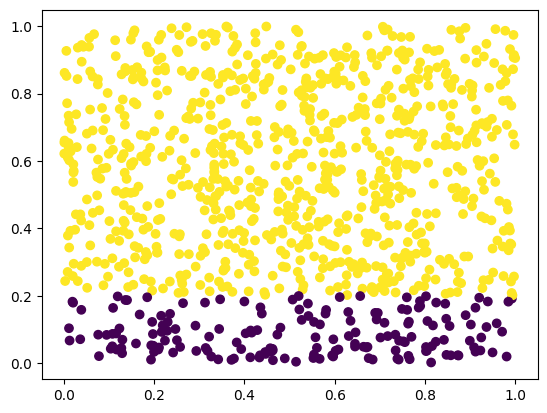

In [27]:
plt.figure()
plt.scatter(data_d1[:,0],data_d1[:,1],c=data_d1[:,-1])

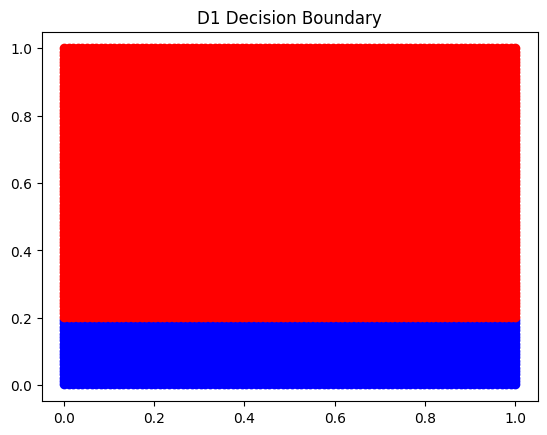

In [28]:
plt.title("D1 Data Set")
dt1.plot_boundary(data_d1,root_d1,100,"D1 Decision Boundary",filename="d1_boundary.png")

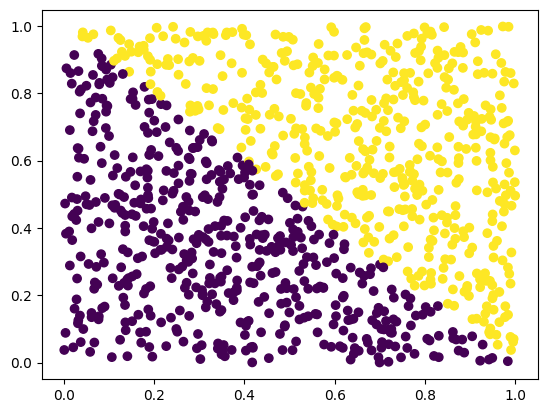

In [29]:
plt.figure()
plt.scatter(data_d2[:,0],data_d2[:,1],c=data_d2[:,-1])


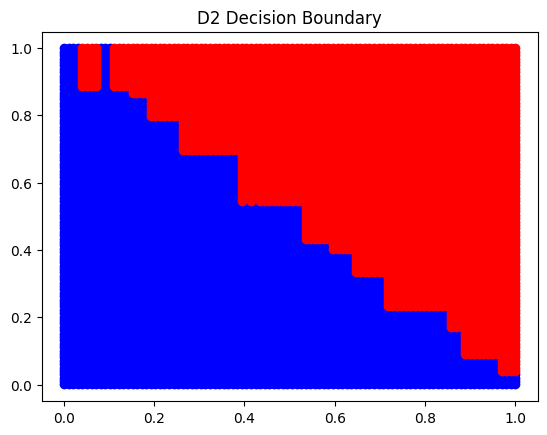

In [30]:
plt.title("D2 Data Set")
dt1.plot_boundary(data_d2,root_d2,100,"D2 Decision Boundary",filename="d2_boundary.png")

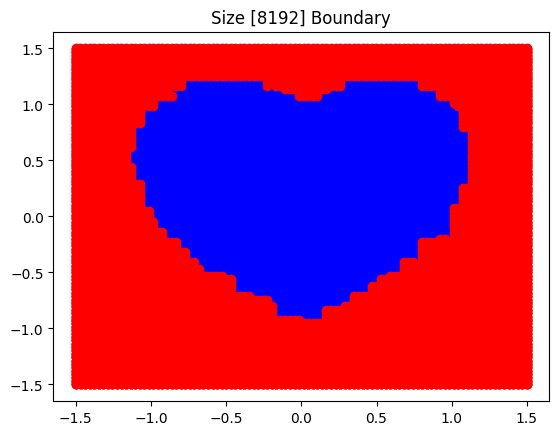

In [11]:
data_big = np.loadtxt("Dbig.txt")
np.random.shuffle(data_big)
data_test = data_big[8192:,:]
data_big = data_big[:8192,:]

nodes = []
errs = []
size_set = np.array([32,128,512,2048,8192]).reshape(5,1)

dt = DecTree()
for size in size_set:
    data_train = data_big[:size[0],:]
    root = dt.make_subtree(data_train)
    dt.plot_boundary(data_train,root,100,"Size "+str(size)+" Boundary",filename="size_"+str(size)+"_boundary.png")
    nodes.append(dt.count_num_node(root))
    errs.append(dt.calc_error(root,data_test))

In [34]:
nodes = np.array(nodes).reshape(5,1)
errs = np.array(errs).reshape(5,1)
temp = np.concatenate((size_set,nodes,errs),axis=1)
print("Number of nodes in the tree:"+str(dt.count_num_node(root)))

Number of nodes in the tree:271


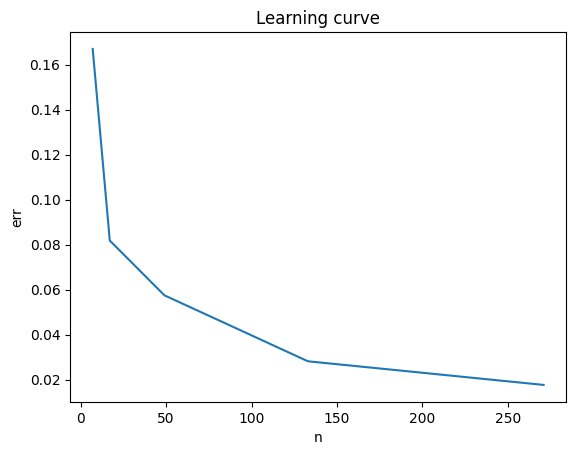

In [35]:
plt.plot(nodes,errs)
plt.title("Learning curve")
plt.xlabel("n")
plt.ylabel("err")
plt.savefig("manual_error_rate.png")

In [37]:
nodes_sklearn = []
errs_sklearn = []

dtc = DTC(criterion='entropy')
for size in size_set:
    data_train = data_big[:size[0],:]
    dtc.fit(data_train[:,:-1],data_train[:,-1])
    errs_sklearn.append(1-dtc.score(data_test[:,:-1],data_test[:,-1]))
    nodes_sklearn.append(dtc.tree_.node_count)

nodes_sklearn = np.array(nodes_sklearn).reshape(5,1)
errs_sklearn = np.array(errs_sklearn).reshape(5,1)
temp = np.concatenate((size_set,nodes_sklearn,errs_sklearn),axis=1)
df = pd.DataFrame(data=temp,columns=['Size','nodes','err'])
print("Number of nodes in the tree:"+str(dtc.tree_.node_count))

Number of nodes in the tree:211


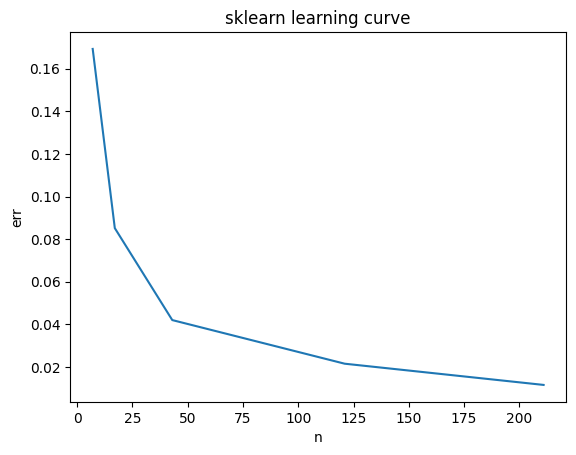

In [38]:
plt.plot(nodes_sklearn,errs_sklearn)
plt.title("sklearn learning curve")
plt.xlabel("n")
plt.ylabel("err")
plt.savefig("sklearn_error_rate.png")